<h1><center> Implementation of BCDU-Net model for skin lesion segmentation </center></h1>
Student ID: B726960


## Install dependencies
Checks whether the project is ran on google colab, if so, a pyunpack depedency is install which will be used to unpack .rar files

In [1]:
if 'google.colab' in str(get_ipython()):
  !pip install patool

## Importing libraries
All libraries used to implement this deep learning implementation are imported

In [2]:
import numpy as np
import glob
import cv2
import imageio
import zipfile
import os 
from tqdm import tqdm
import requests
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Model
from keras.optimizers import *
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import patoolib
from scipy.spatial import distance

##Downloading and unpacking data
Defining a function to download the data from url. A requests library is used to download content from the provided URL link. This sends a HTTP Get request to the specified URL and returns a response object containing the content. The content is then iterated over in small block sizes and saved into a zip file. A progress bar has been implemented using the 'tqdm' library to display the progress of the download.

In [3]:
def download_data(url, directory_name):
    response = requests.get(url, stream=True) #HTTP GET Request for url
    total_size_in_bytes = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kilobyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True, desc="Downloading ")
    with open(directory_name, 'wb') as file:
        for data in response.iter_content(block_size):
            # File too large for singular download so stream the download in chunks
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    # Finally, close the progress bar
    # Error check
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

Download and unzip ISIC-18 data. It is first checked whether the zip file or the NumPy file already exists, if so, this step is skipped so data is not re-downloaded. If the data has not been previously downloaded, both the ISIC-18 lesion images and ground truth masks are downloaded.

In [4]:
# Specify file name to store zipped lesion images and masks
zip_lesion_imgs = 'isic-image_data.zip'
zip_mask_imgs = 'isic-mask_data.zip'

# Url link to download ISIC-18 skin lesion images along with corresponding masks
isic_lesion_images_url = 'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip'
isic_gt_masks_url = 'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip'

# checks whether zip file or ISIC numpy directory already exists
if not os.path.exists(zip_lesion_imgs) and not os.path.exists('ISICNumpy'):
  download_data(isic_lesion_images_url, zip_lesion_imgs)
  download_data(isic_gt_masks_url, zip_mask_imgs)

Defining a method to unzip image data files. It first checks whether the file exists, if so, checks whether it is a .rar file or a .zip file. Based on the file type, an appropriate method is used to extract the content.

In [5]:
def unzip_file(folder):
  if os.path.exists(folder): #Check whether specified folder path exists
    if folder.endswith('.rar'): #If file is a .rar file, use patoolib library to extract content
      patoolib.extract_archive(folder)
    elif folder.endswith('.zip'): # If file is .zip file, use zipfile library to extract content
      with zipfile.ZipFile(folder, 'r') as zip_ref:
        # display progress bar
        for content in tqdm(zip_ref.infolist(), desc="Extracting data "):
          zip_ref.extract(content, 'ISIC18Dataset')
    os.remove(folder)

Unzip both ISIC-18 and PH2 image data if exists

In [6]:
unzip_file(zip_lesion_imgs)
unzip_file(zip_mask_imgs)
unzip_file('PH2Dataset.rar')

##Read and prepare downloaded data
This section loads the downloaded skin lesion data along with their corresponding masks and prepares it so it can be used for training the segmentation model.

In [7]:
# Define image dimensions
width = 128
height = 128
channels = 3

# Define ISIC directory
isic_dataset_directory = "ISIC18Dataset/"
isic_training_directory = "ISIC2018_Task1-2_Training_Input"
isic_mask_directory = "ISIC2018_Task1_Training_GroundTruth/"

# Define PH2 directory
ph2_directory = "PH2Dataset/PH2 Dataset images"

Retrieve skin lesion image files using the 'glob' library and create a zeros numpy array for storing ISIC lesion images and masks. The size of array for lesion images is (number of images, height, width, and channels), for masks, channels is removed since ground truth masks are binary images.

In [8]:
# Use glob to retrieve all file names of skin lesions in the ISIC directory
isic_data_list = glob.glob(isic_dataset_directory + isic_training_directory + '/*.jpg')

# Get the sample size of ISIC-18 dataset
isic_size = len(isic_data_list)

# Create zeros numpy array to store ISIC skin lesion images and masks
isic_image_data = np.zeros([isic_size, width, height, channels])
isic_mask_data = np.zeros([isic_size, width, height])

The image path files retrieved above are iterated over and resized to dimensions specified above using resize() method provided by OpenCV. Skin lesion images are then stored in an array with their corresponding ground truth masks in a separate numpy array at the same index.

In [9]:
print('Reading ISIC 2018')
for i, image in enumerate(tqdm(isic_data_list, desc="Reading: ")):
  # read and resize skin lesion image and add it to a numpy array containing skin lesion images
  img = imageio.imread(image)
  img = np.double(cv2.resize(img, (width, height)))
  isic_image_data[i, :, :, :] = img

  # get image ID to get corresponding ground truth mask
  image_id = image[len(image) - 16: len(image) - 4]
  # get path to ground truth image
  isic_mask_file = isic_dataset_directory + isic_mask_directory + image_id + '_segmentation.png'
  # read and resize ground truth image and add it to numpy array containing ground truth masks
  isic_mask = imageio.imread(isic_mask_file)
  isic_mask = np.double(cv2.resize(isic_mask, (width, height)))
  isic_mask_data[i, :, :] = isic_mask

print('Finished reading ISIC 2018')

Reading:   0%|          | 3/2594 [00:00<01:43, 25.03it/s]

Reading ISIC 2018


Reading: 100%|██████████| 2594/2594 [09:27<00:00,  4.57it/s]

Finished reading ISIC 2018


If PH2Dataset path containing PH2 data exists, the image paths files are retrieved. A numpy zeros array is then created, which will store PH2 skin lesion data and ground truth masks. Each image file path is read using 'imageio' library and resized using OpenCV. Skin lesion images along with their corresponding masks are stored in separate numpy arrays at the same.

In [10]:
ph2_image_data = None
ph2_mask_data = None
# Check whether PH2 data exists, else display error message to user
if os.path.exists("PH2Dataset"):
  print("Reading PH2 data")
  # Get file paths of images
  ph2_data_list = next(os.walk(ph2_directory))[1]

  # Zeros numpy array for storing skin lesion images and corresponding ground truth masks
  ph2_image_data = np.zeros([200, width, height, channels])
  ph2_mask_data = np.zeros([200, width, height])

  for i, image in enumerate(tqdm(ph2_data_list, desc="Reading: ")):
    # get lesion image
    img = imageio.imread((ph2_directory + "/" + image+ "/" + image +"_Dermoscopic_Image/"+ image +".bmp"))
    img = np.double(cv2.resize(img, (width, height)))
    ph2_image_data[i, :, :, :] = img

    # get corresponding ground truth image
    ph2_mask = imageio.imread(ph2_directory + "/" + image + "/" + image +"_lesion/"+ image +"_lesion.bmp")
    ph2_mask = np.double(cv2.resize(ph2_mask, (width, height)))
    ph2_mask_data[i, :, :] = ph2_mask
  print("Finished reading PH2 data")
else:
  print("Cannot find PH2Dataset directory")

Reading:   0%|          | 0/200 [00:00<?, ?it/s]

Reading PH2 data


Reading: 100%|██████████| 200/200 [00:03<00:00, 52.99it/s]

Finished reading PH2 data


Defining a method to normalise image data. The distribution of pixels is centered on the value of 0 by calculating the mean pixel value and subtracting it across the colour channels, once centering is performed, the image is then normalised.

In [11]:
# normalising and centering pixels
def normalise_dataset(imgs):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs - imgs_mean) / imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (
                np.max(imgs_normalized[i]) - np.min(imgs_normalized[i]))) * 255
    return imgs_normalized

Normalising ISIC-18 images and PH2 images if exists.




In [12]:
# Normalising ISIC image data
isic_image_data = normalise_dataset(isic_image_data)
isic_mask_data = isic_mask_data/255.

# Normalise PH2 image data if it exists
if ph2_image_data is not None:
  ph2_image_data = normalise_dataset(ph2_image_data)
  ph2_mask_data = ph2_mask_data/255.

print("Normalised images")

Normalised images


Split dataset into training, validation and test data to evaluate performance of the model without any bias. The training, validation and testing data is split into 70%, 10% and 20% respectively, using the train_test_split9) method provided by skelarn library. The train_test_split() method shuffles the data before splitting it, hence splitting data in a way that is representative of the whole dataset.

In [13]:
# split training, validation, and testing data into 70%, 10% and 20% respectively 
isic_train_img, isic_test_img, isic_train_mask, isic_test_mask = train_test_split(isic_image_data, isic_mask_data, test_size=0.2) # Split 80% training, 20% testing
isic_train_img, isic_val_img, isic_train_mask, isic_val_mask = train_test_split(isic_train_img, isic_train_mask, test_size=0.1) # Using split training data, split again into 90% and 10%, giving overall 20% for testing, 80% for training and 10% for validation

print("Finished splitting ISIC data")

if ph2_image_data is not None:
  ph2_train_img, ph2_test_img, ph2_train_mask, ph2_test_mask = train_test_split(ph2_image_data, ph2_mask_data, test_size=0.2)
  ph2_train_img, ph2_val_img, ph2_train_mask, ph2_val_mask = train_test_split(ph2_train_img, ph2_train_mask, test_size=0.1)

  print("Finished splitting PH2 data")

Finished splitting ISIC data
Finished splitting PH2 data


Save train, test, and validation data as a numpy array files using np.save() method, which takes the path name and the array of data to be saved. This increasing loading the data for training deep learning model.

In [14]:
def save_numpy_files(directory, train_img, test_img, val_img, train_mask, test_mask, val_mask):
  np.save(directory + '/data_train', train_img)
  np.save(directory + '/data_test', test_img)
  np.save(directory + '/data_val', val_img)

  np.save(directory + '/mask_train', train_mask)
  np.save(directory + '/mask_test', test_mask)
  np.save(directory + '/mask_val', val_mask)

isic_numpy_directory = "ISICNumpy"
ph2_numpy_directory = "PH2Numpy"

# save ISIC data in numpy files if not already existing
if not os.path.exists(isic_numpy_directory):
  os.makedirs(isic_numpy_directory)
  save_numpy_files(isic_numpy_directory, isic_train_img, isic_test_img, isic_val_img, isic_train_mask, isic_test_mask, isic_val_mask)
  print("ISIC data saved as numpy arrays")

# save PH2 data in numpy files if not already existing
if not os.path.exists(ph2_numpy_directory) and os.path.exists(ph2_directory):
  os.makedirs(ph2_numpy_directory)
  save_numpy_files(ph2_numpy_directory, ph2_train_img, ph2_test_img, ph2_val_img, ph2_train_mask, ph2_test_mask, ph2_val_mask)
  print("PH2 data saved as numpy arrays")

A method for laoding numpy files is defined. This method returns training, testing and validation skin lesion images and ground truth masks.

In [15]:
def load_data(directory):
  train_data = np.load(directory + '/data_train.npy')
  test_data = np.load(directory + '/data_test.npy')
  val_data = np.load(directory + '/data_val.npy')

  train_mask = np.load(directory + '/mask_train.npy')
  test_mask = np.load(directory + '/mask_test.npy')
  val_mask = np.load(directory + '/mask_val.npy')

  return train_data, test_data, val_data, train_mask, test_mask, val_mask

# Load ISIC skin lesion images and ground truth iamges
isic_train_data, isic_test_data, isic_val_data, isic_train_mask, isic_test_mask, isic_val_mask = load_data(isic_numpy_directory)
print('ISIC dataset loaded')

# If PH2 Numpy directory exists, load PH2 skin lesion images and ground truth images
if os.path.exists(ph2_numpy_directory):
  ph2_train_data, ph2_test_data, ph2_val_data, ph2_train_mask, ph2_test_mask, ph2_val_mask = load_data(ph2_numpy_directory)
  print('PH2 dataset loaded')

ISIC dataset loaded
PH2 dataset loaded


## Define methods for performing evaluation

This method calculates area based metrics including the border error percentage (XOR), True positive rate (TPR) and False positive rate (FPR). Since the stated evaluation metrics are based on true/false positive/negative values, such values are computed. This is implemented using the confusion_matrix() method which takes as a parameter, ground truth images along with predicted binary images. Thi returns a matrix of true/false positive/negative values. The method .ravel() is used to split the matrix values, which are then used to calculate the different evaluation metrics.



In [16]:
def calc_metrics(ground_truth, predictions):
  y_scores = predictions.reshape(predictions.shape[0]*predictions.shape[1]*predictions.shape[2]*predictions.shape[3], 1)
  y_true = ground_truth.reshape(ground_truth.shape[0]*ground_truth.shape[1]*ground_truth.shape[2], 1)
  
  # Threshold
  y_true   = np.where(y_true>0.5, 1, 0)
  
  # Confusion matrix
  tn, fp, fn, tp =  confusion_matrix(y_true, y_scores).ravel()

  # Calculate border error
  xor = float(fp+fn)/float(tp+fn) * 100

  # Calculate TPR
  tpr = float(tp)/float(tp+fn) * 100

  # Calculate FPR
  fpr = float(fp)/float(fp+tn) * 100

  # Print results
  print("Border Error Metric mean: " + str(xor))
  print("TPR: " + str(tpr))
  print("FPR: " + str(fpr))

This section calculated the modified Hausdorff distance. A modified directed hausdorff distance is first calculated, which gets all the minimum euclidean distances for all points in A. The mean of all the minimum distances is then calculated.
The modified Hausdorff distance is asymmetric, meaning the average minimum distance from A to B may not be the same as from B to A. Therefore, the modified directed hausdorff distance is calculated for both A to B and B to A, and a mean of the two is taken. 
This is repeated for all of the ground truth and predicted binary images and the average modified hausdorff distance is outputted.

In [17]:
def modified_directed_hausdorff(A, B):
  min_euclidean_distance = []
  for a in A:
    euclidean_dist = []
    # Get all euclidean distances from point a to all points in B
    for b in B:
      euclidean_dist.append(distance.euclidean(a, b))

    # Calculate min distance and add it to min_euclidean_distance array
    min_euclidean_distance.append(min(euclidean_dist))

  # Calculate average of min distances
  return np.mean(min_euclidean_distance)


# Since min distance from A to B is not always the same as B to A, the modified directed hausdorff distance is calculated from A to B, and from B to A. The mean of the two values is then taken.
def modified_hausdorff_distance(A, B):
    mean_distance = (modified_directed_hausdorff(A, B) + modified_directed_hausdorff(B, A)) / 2

    return mean_distance


# Calculate the overall average hausdorff distance of all images
def calculate_modified_hausdorff_distance(ground_truth, predictions):
    sum_hausdorff = 0

    # Threshold
    ground_truth = np.where(ground_truth>0.5, 1, 0)
    
    total_images = predictions.shape[0]

    # Get boundary line for each ground truth image and predicted image. Using those values calculate the modified hausdorff distance
    for i in range(0, total_images):

        contours, hierarchy = cv2.findContours(np.uint8(ground_truth[i]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours2, hierarchy2 = cv2.findContours(np.uint8(predictions[i]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) != 0 and len(contours2) != 0:
            ground_truth_border = max(contours, key=cv2.contourArea)
            prediction_border = max(contours2, key=cv2.contourArea)
            hausdorff = modified_hausdorff_distance(ground_truth_border[0, :, :], prediction_border[0, :, :])
            sum_hausdorff += hausdorff

    # Get the average hausdorff distance for all images
    hausdorff_avg = sum_hausdorff / total_images

    print("Modified Hausdorff Distance: " + str(hausdorff_avg))

##Displaying image results

A method is defined to display results data. This includes the original image, ground truth mask, predicted segmentation, predicted segmentation after thresholding, and the borders of ground truth and predicted border drawn on the original image to be able to make a visual comparison. 

The border is obtained using the findContours() method provided by OpenCV, which is then drawn on an image using drawContours() method.

Results are displaying using the matplotlib library.

In [35]:
def display_image_results(test_data, ground_truth_data, predictions, thresh_predictions):

  for idx in range(1, 10):
    img = np.uint8(test_data[idx])
    contours, hierarchy = cv2.findContours(np.uint8(thresh_predictions[idx]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 0:
      cntr = max(contours, key = cv2.contourArea)
      cv2.drawContours(img, [cntr], 0, (56, 255, 76), 1)

    contours2, hierarchy2 = cv2.findContours(np.uint8(ground_truth_data[idx]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours2) != 0:
      cntr2 = max(contours2, key = cv2.contourArea)
      cv2.drawContours(img, [cntr2], 0, (0, 85, 255), 1)

    plt.figure(figsize=(16,16))
    plt.subplot(1,5,1)
    plt.imshow(np.uint8(test_data[idx]))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1,5,2)
    plt.imshow(np.squeeze(ground_truth_data[idx]), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    plt.subplot(1,5,3)
    plt.imshow(np.squeeze(predictions[idx]), plt.cm.binary_r)
    plt.title('Predicted Segmentation Mask')
    plt.axis('off')
    plt.subplot(1,5,4)
    plt.imshow(np.squeeze(thresh_predictions[idx]), plt.cm.binary_r)
    plt.title('Predicted After Thresholding')
    plt.axis('off')
    plt.subplot(1,5,5)
    plt.imshow(img)
    plt.title('GT and predicted border')
    plt.axis('off')
    plt.show()

##Defining BCDU-Net model
This method defines a modified U-Net model called BCDU-Net. The model is then configured using the compile() method provided by Keras, which takes as input the optimiser type with the learning rate, and is applied to the model. The optimiser affects the learning rate of the model. The implementation of the model has been taken from [1] which has been implemented by [2][3].

References:

[1] R. Azad, "BCDU-Net", Available at:https://github.com/rezazad68/BCDU-Net/blob/master/Skin%20Lesion%20Segmentation/models.py , 2020, Accessed: 10 April 2020

[2] R. Azad, M. Asadi, Mahmood Fathy and Sergio Escalera "Bi-Directional ConvLSTM U-Net with Densely Connected Convolutions ", ICCV, 2019.

[3] M. Asadi, R. Azad, Mahmood Fathy and Sergio Escalera "Multi-level Context Gating of Embedded Collective Knowledge for Medical Image Segmentation", The first two authors contributed equally. arXiv:2003.05056, 2020.

In [19]:
def define_model(input_size):
  N = input_size[0]
  inputs = Input(input_size)
  # Encoding Path 
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)

  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  # Densely connected convolutions, in total 3 blocks
  # D1
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
  conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
  drop4_1 = Dropout(0.5)(conv4_1)
  # D2
  conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(drop4_1)
  conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(conv4_2)
  conv4_2 = Dropout(0.5)(conv4_2)
  # D3
  merge_dense = concatenate([conv4_2, drop4_1], axis=3)
  conv4_3 = Conv2D(512, 3, activation='relu', padding='same')(merge_dense)
  conv4_3 = Conv2D(512, 3, activation='relu', padding='same')(conv4_3)
  drop4_3 = Dropout(0.5)(conv4_3)

  # Decoding path
  # Each step consists of upsampling followed by feature processing using ConvLSTM2 layer
  up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same')(drop4_3)
  up6 = BatchNormalization(axis=3)(up6)
  up6 = Activation('relu')(up6)

  x1 = Reshape(target_shape=(1, np.int32(N / 4), np.int32(N / 4), 256))(drop3)
  x2 = Reshape(target_shape=(1, np.int32(N / 4), np.int32(N / 4), 256))(up6)
  merge6 = concatenate([x1, x2], axis=1)
  # BConvLSTM (ConvLSTM go_backwards = True processines input data into forward and backward paths)
  merge6 = ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=False, go_backwards=True)(merge6)

  conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
  conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

  up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same')(conv6)
  up7 = BatchNormalization(axis=3)(up7)
  up7 = Activation('relu')(up7)

  x1 = Reshape(target_shape=(1, np.int32(N / 2), np.int32(N / 2), 128))(conv2)
  x2 = Reshape(target_shape=(1, np.int32(N / 2), np.int32(N / 2), 128))(up7)
  merge7 = concatenate([x1, x2], axis=1)
  merge7 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False, go_backwards=True)(merge7)

  conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
  conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

  up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same')(conv7)
  up8 = BatchNormalization(axis=3)(up8)
  up8 = Activation('relu')(up8)

  x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
  x2 = Reshape(target_shape=(1, N, N, 64))(up8)
  merge8 = concatenate([x1, x2], axis=1)
  merge8 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False, go_backwards=True)(merge8)

  conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
  conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
  conv8 = Conv2D(2, 3, activation='relu', padding='same')(conv8)
  conv9 = Conv2D(1, 1, activation='sigmoid')(conv8)

  model = Model(inputs=inputs, outputs=conv9)
  model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
  return model

##Build and train model

This method defined builds and trains a deep learning model. The model is first defined with the specified width, height and channels dimension. Once the model is defined, it is trained on a given training dataset and the performance of the model during the training stage is evaluated using data not used for training (validation data). fit() method provided by keras is used to train the model.

In [20]:
def train_model_on_dataset(train_data, train_mask, val_data, val_mask):
  model = define_model((width, height, channels))
  model.summary()

  batch_size = 8
  nb_epoch = 30

  history = model.fit(train_data, train_mask,
                      batch_size=batch_size,
                      epochs=nb_epoch,
                      shuffle=True,
                      verbose=1,
                      validation_data=(val_data, val_mask))
  
  return model, history

## Train model on ISIC-18 training data

The model is training and validated on ISIC-18 data

In [21]:
# Train and validate on ISIC-18 data
isic_trained_model, history_isic = train_model_on_dataset(isic_train_data, isic_train_mask, isic_val_data, isic_val_mask)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

The accuracy and loss graphs are displayed to see the performance of the model during the training

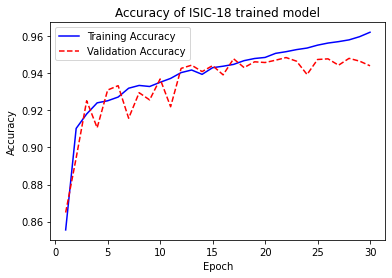

In [22]:
plt.title('Accuracy of ISIC-18 trained model')
plt.plot(range(1, 30+1), history_isic.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(range(1, 30+1), history_isic.history['val_accuracy'], '--', color='r', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

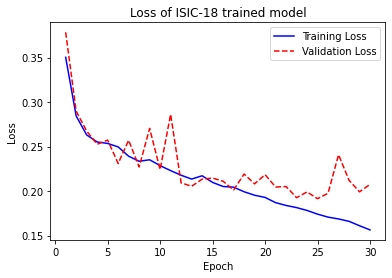

In [23]:
plt.title('Loss of ISIC-18 trained model')
plt.plot(range(1, 30+1), history_isic.history['loss'], color='blue', label='Training Loss')
plt.plot(range(1, 30+1), history_isic.history['val_loss'], '--', color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Evaluate trained model on ISIC-18 data

The ISIC-18 trained model is tested on isic test data. This is performed using the predict() method provided by keras, which takes test data and batch size as an argument. 

Thresholding is performed to sharpen the border of predicted results; if the value is greater than 0.5, the value is assigned to 1, else, value is given 0. 

Metrics based on true/false positive/negative value is then calculated and returned. A modified Hausdorff distance is also calculated.

In [24]:
# predict on ISIC-18 data
isic_predictions = isic_trained_model.predict(isic_test_data, batch_size=8, verbose=1)

# Threshold
isic_predictions_thresh   = np.where(isic_predictions>0.5, 1, 0)

# Calculate metrics
calc_metrics(isic_test_mask, isic_predictions_thresh)
calculate_modified_hausdorff_distance(isic_test_mask, isic_predictions_thresh)


65/65 [==============================] - 4s 56ms/step
Border Error Metric mean: 22.544325246013802
TPR: 85.99723117546758
FPR: 2.4093301043684203
Modified Hausdorff Distance: 7.925866913700945


Example of predicted results

Ground truth border is represented by blue, and computer detected border is represented by green.

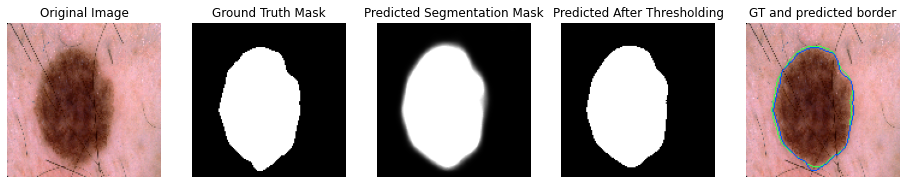

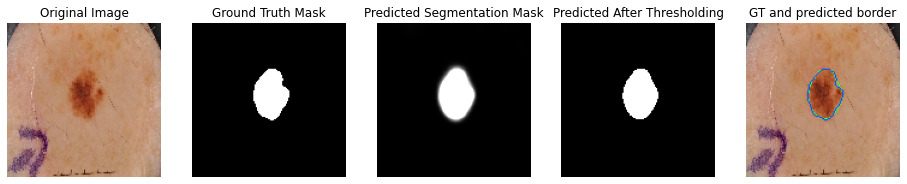

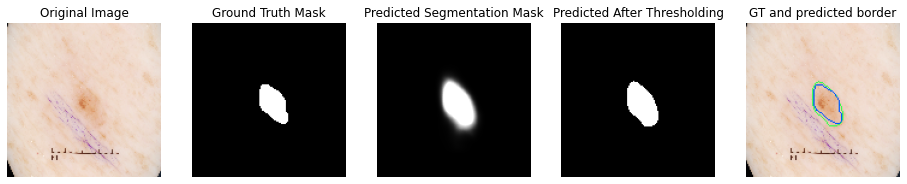

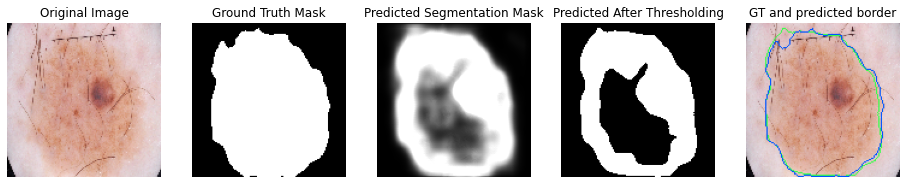

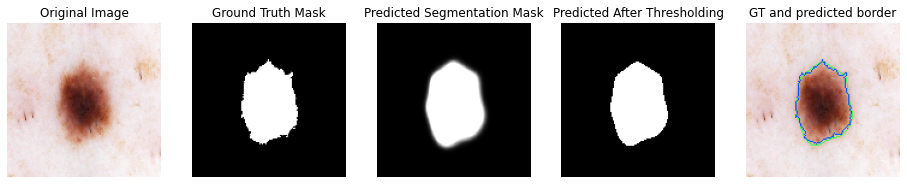

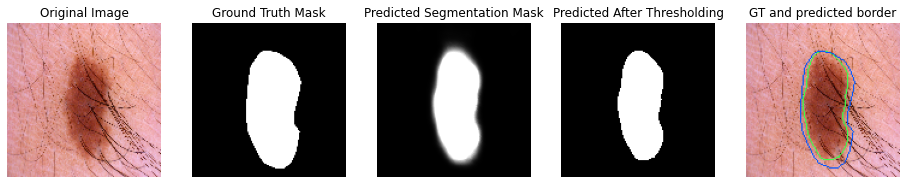

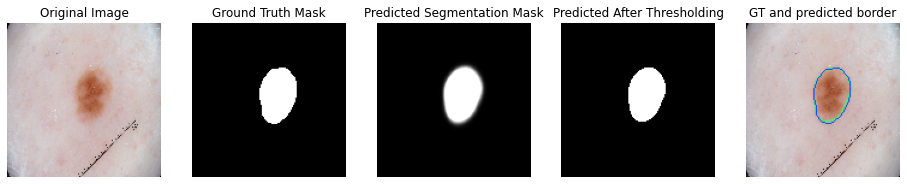

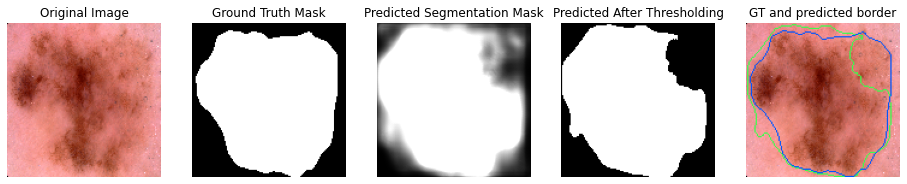

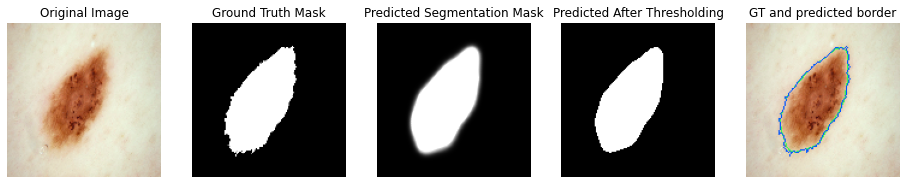

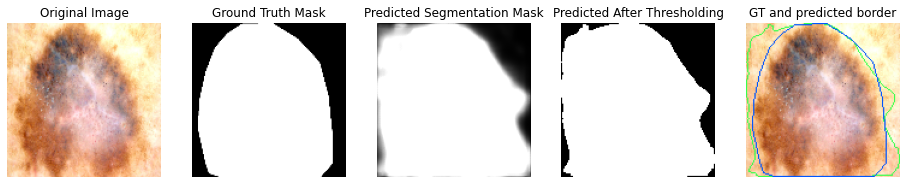

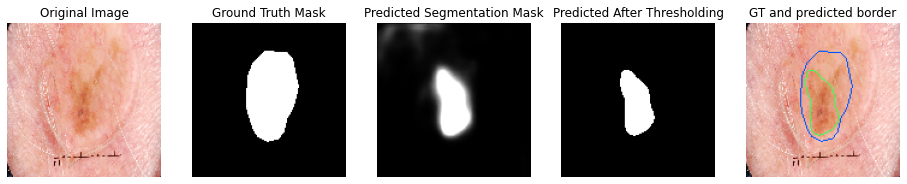

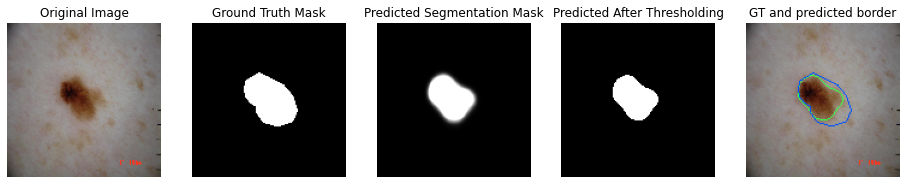

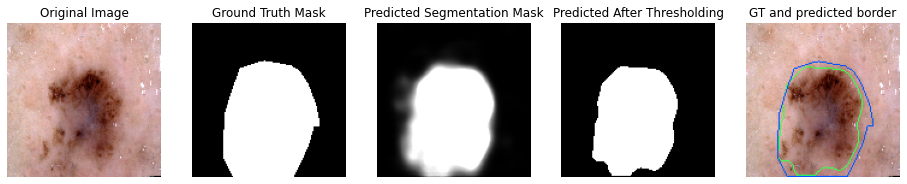

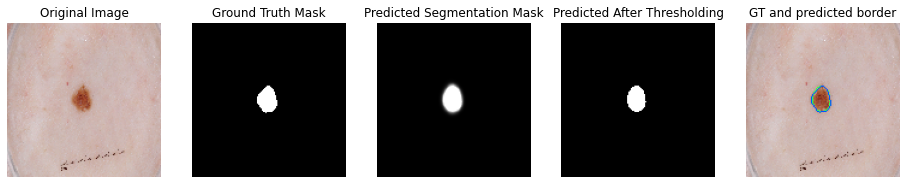

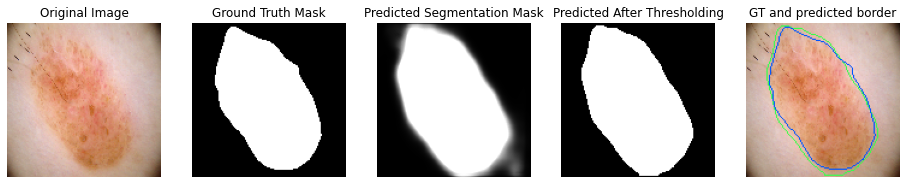

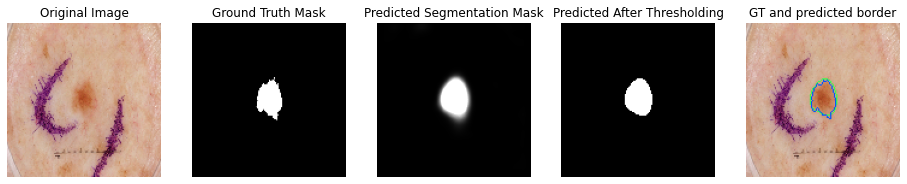

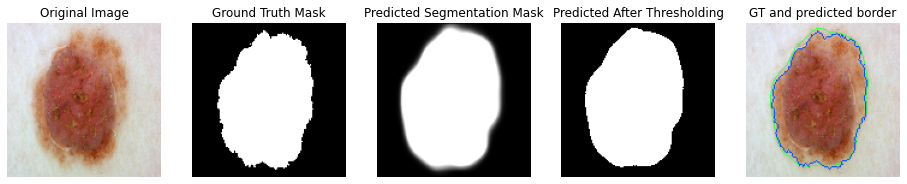

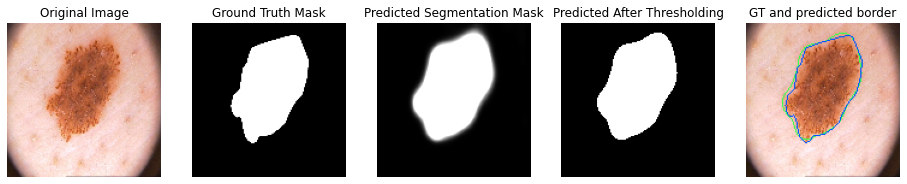

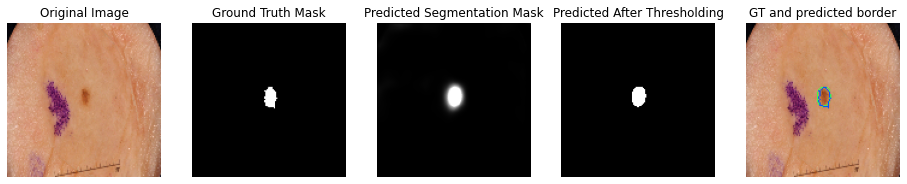

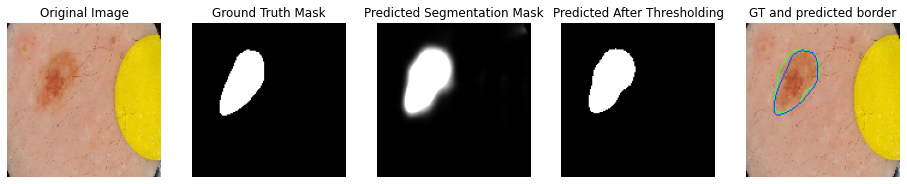

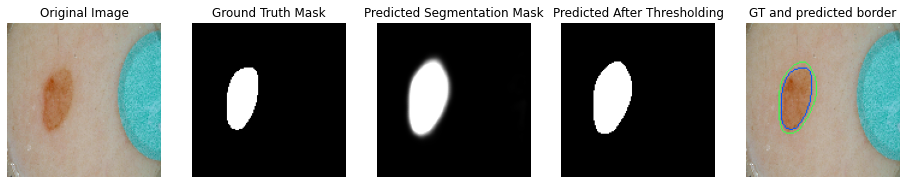

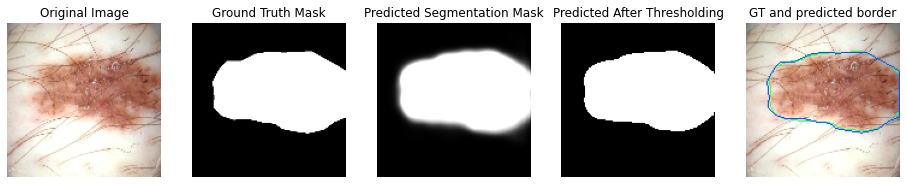

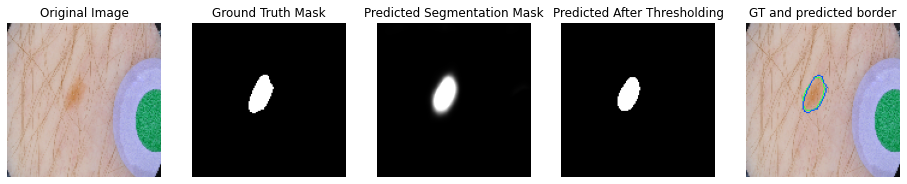

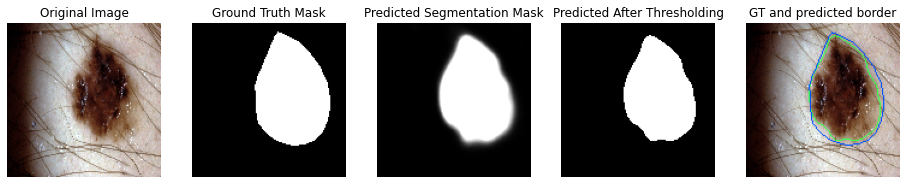

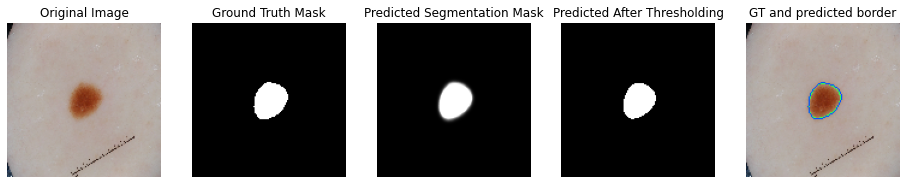

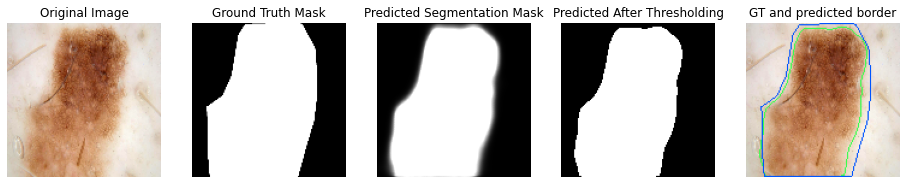

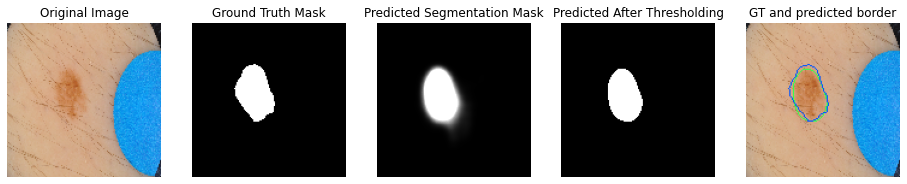

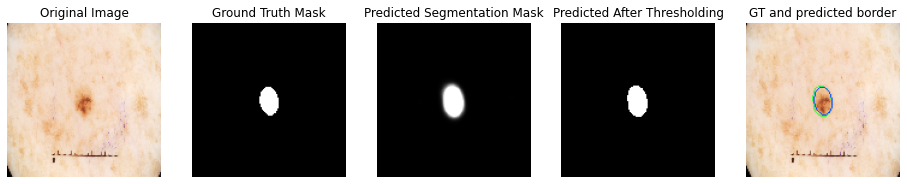

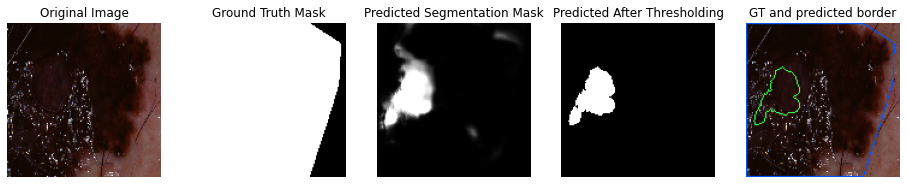

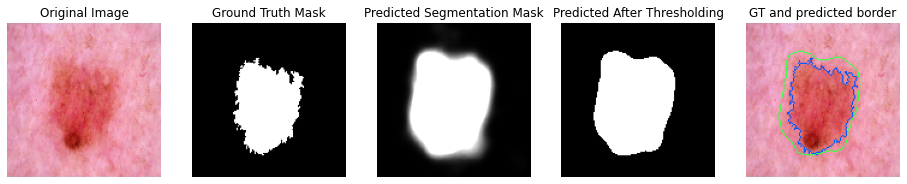

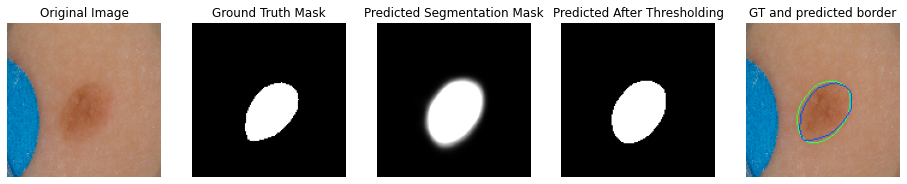

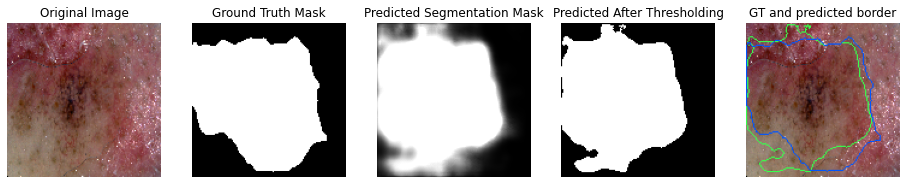

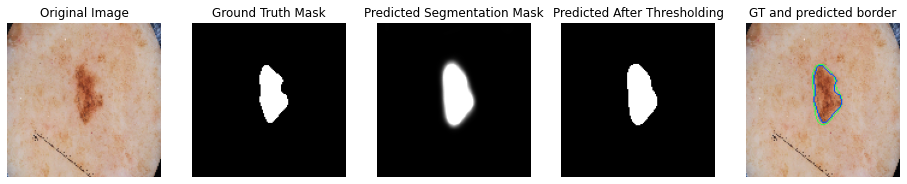

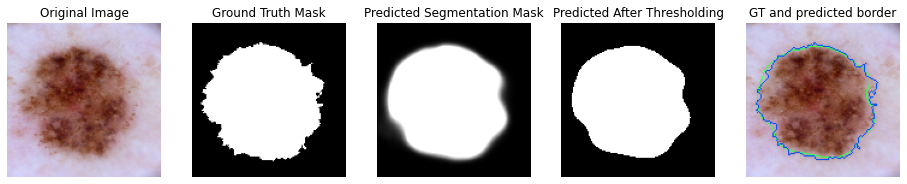

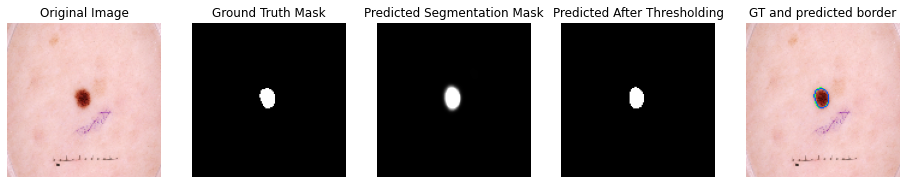

In [36]:
display_image_results(isic_test_data, isic_test_mask, isic_predictions, isic_predictions_thresh)

###Evaluate trained model on PH2 data if PH2 data exists

The ISIC-18 trained model is tested on the PH2 dataset. This is performed using the predict() method provided by keras.

Thresholding is performed to sharpen the border of predicted results; if the value is greater than 0.5, the value is assigned to 1, else, value is given 0.

Objective measures are calculated to be able to evaluate the performance on different datasets.


In [26]:
# predict on PH2 data if exists
if os.path.exists(ph2_numpy_directory):
  ph2_predictions_isic_model = isic_trained_model.predict(ph2_test_data, batch_size=8, verbose=1)

  # Threshold
  ph2_predictions_isic_model_thresh = np.where(ph2_predictions_isic_model>0.4, 1, 0)

  # Calculate metrics
  calc_metrics(ph2_test_mask, ph2_predictions_isic_model_thresh)
  calculate_modified_hausdorff_distance(ph2_test_mask, ph2_predictions_isic_model_thresh)

5/5 [==============================] - 1s 63ms/step
Border Error Metric mean: 23.95310295843979
TPR: 91.95627940929852
FPR: 7.126318440716012
Modified Hausdorff Distance: 6.228832084323648


Display predicted results if PH2 data exists

Ground truth border is represented by blue, and computer detected border is represented by green.

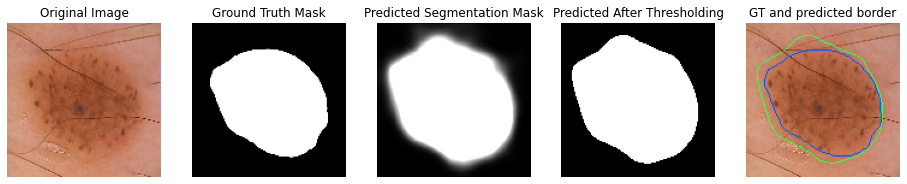

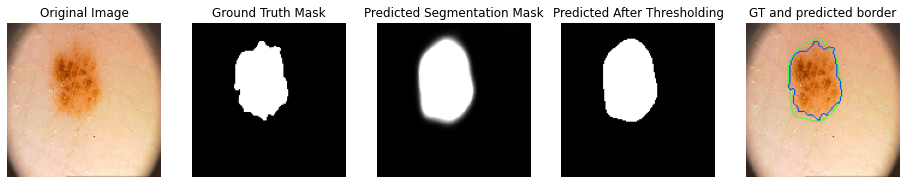

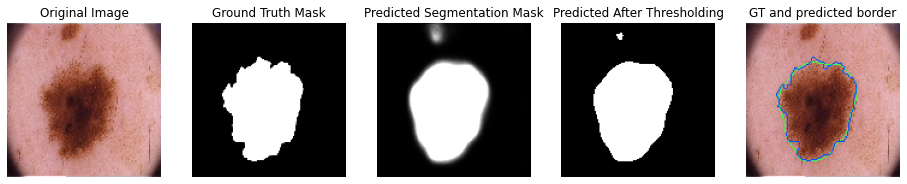

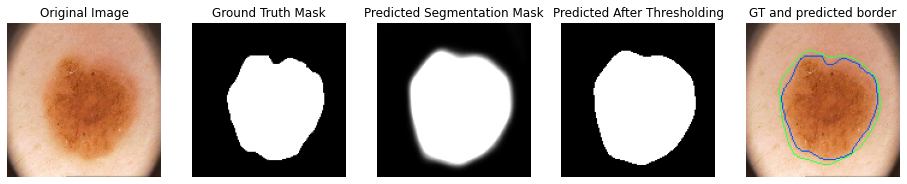

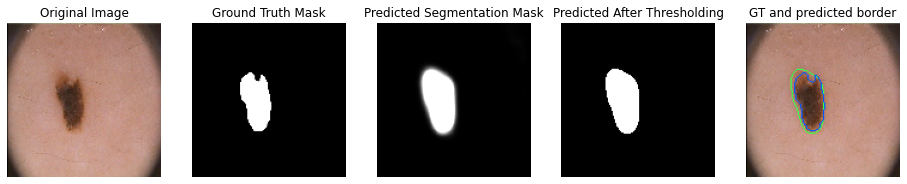

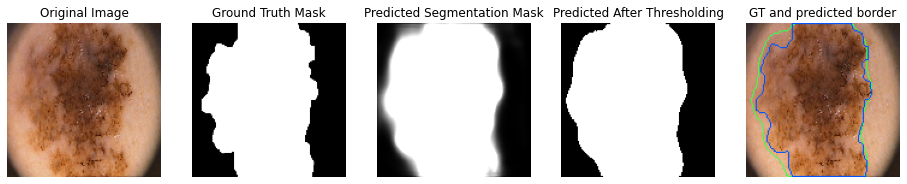

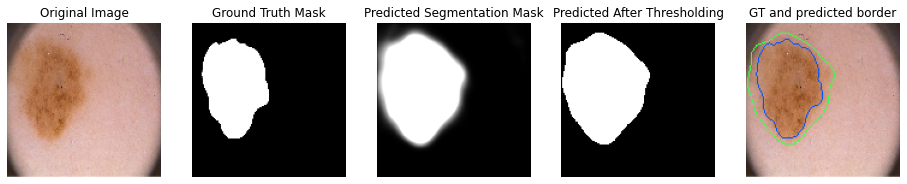

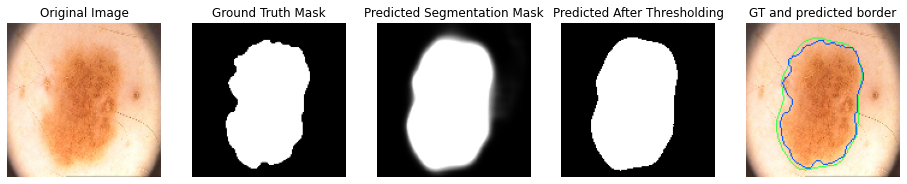

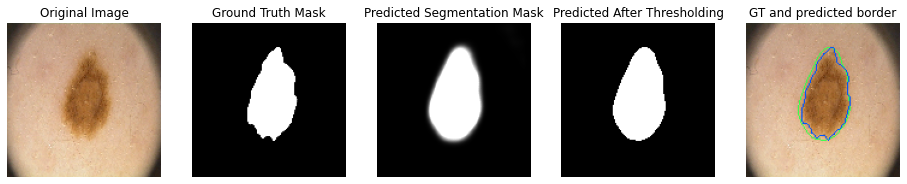

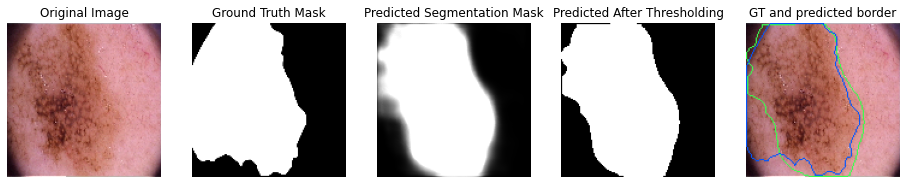

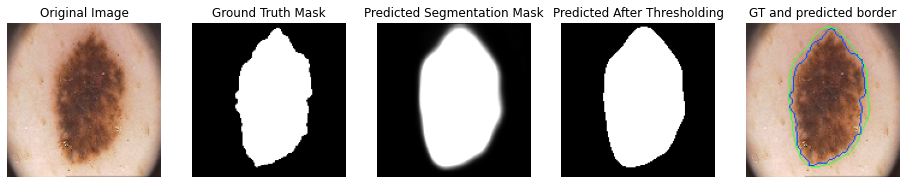

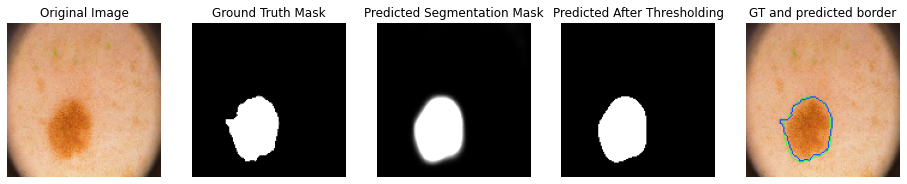

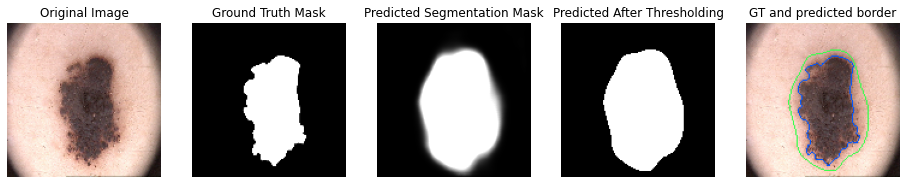

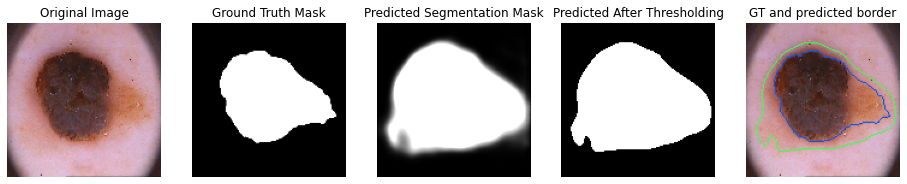

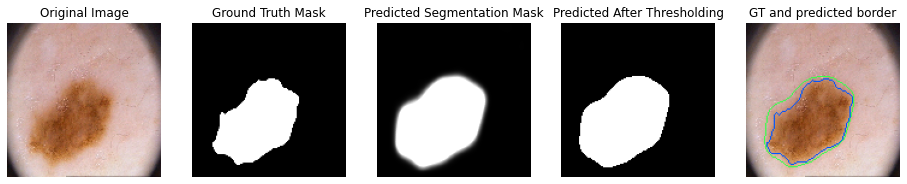

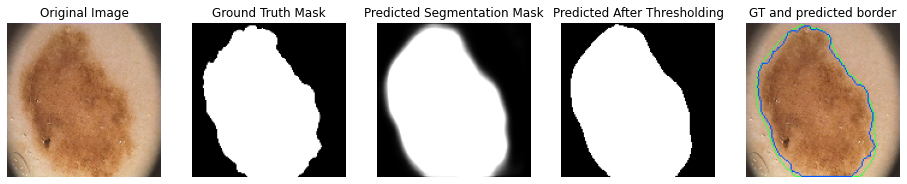

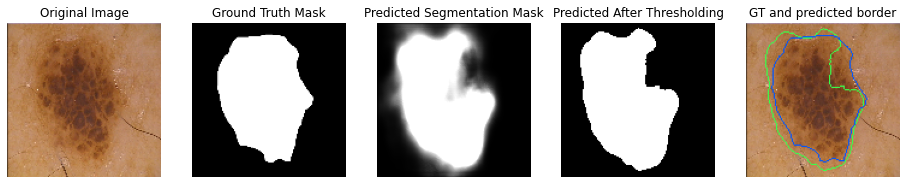

In [27]:
if os.path.exists(ph2_numpy_directory):
  display_image_results(ph2_test_data, ph2_test_mask, ph2_predictions_isic_model, ph2_predictions_isic_model_thresh)

## Train model on PH2 data (if exists)
The model is training and validated on ISIC-18 data

In [28]:
if os.path.exists(ph2_numpy_directory):
  ph2_trained_model, history_ph2 = train_model_on_dataset(ph2_train_data, ph2_train_mask, ph2_val_data, ph2_val_mask)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_21[0][0]                  
____________________________________________________________________________________________

The accuracy and loss graphs are displayed to see the performance of the model during the training

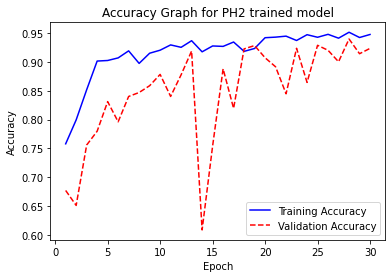

In [29]:
if os.path.exists(ph2_numpy_directory):
  plt.title('Accuracy Graph for PH2 trained model')
  plt.plot(range(1, 30+1), history_ph2.history['accuracy'], color='blue', label='Training Accuracy')
  plt.plot(range(1, 30+1), history_ph2.history['val_accuracy'], '--', color='r', label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

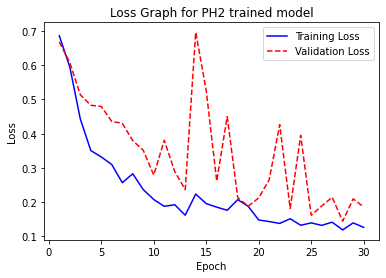

In [30]:
if os.path.exists(ph2_numpy_directory):
  plt.title('Loss Graph for PH2 trained model')
  plt.plot(range(1, 30+1), history_ph2.history['loss'], color='blue', label='Training Loss')
  plt.plot(range(1, 30+1), history_ph2.history['val_loss'], '--', color='r', label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

###Evaluate trained model on PH2 data if PH2 data exists
The PH2 trained model is tested on the PH2 dataset and performance metrics are calculated

In [31]:
if os.path.exists(ph2_numpy_directory):
  ph2_predictions = ph2_trained_model.predict(ph2_test_data, batch_size=8, verbose=1)

  # Threshold
  ph2_predictions_thresh = np.where(ph2_predictions>0.4, 1, 0)

  # Calculate performance
  calc_metrics(ph2_test_mask, ph2_predictions_thresh)
  calculate_modified_hausdorff_distance(ph2_test_mask, ph2_predictions_thresh)

5/5 [==============================] - 1s 60ms/step
Border Error Metric mean: 13.646900987461896
TPR: 88.36452239792446
FPR: 0.9009805177876267
Modified Hausdorff Distance: 6.396293178985482


Example of predicted results

Ground truth border is represented by blue, and computer detected border is represented by green.

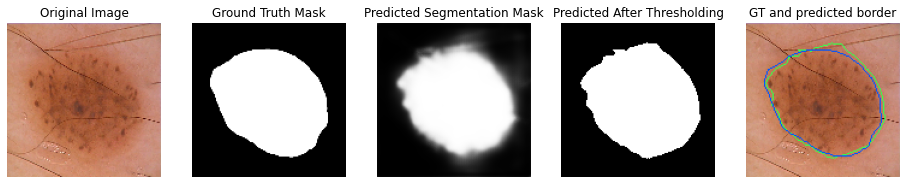

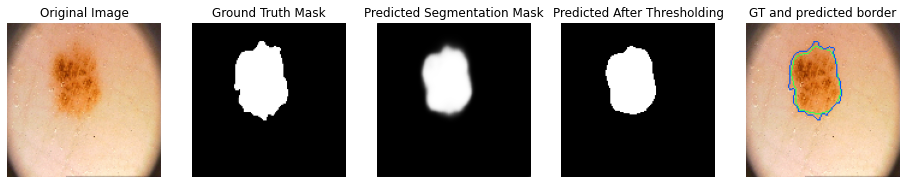

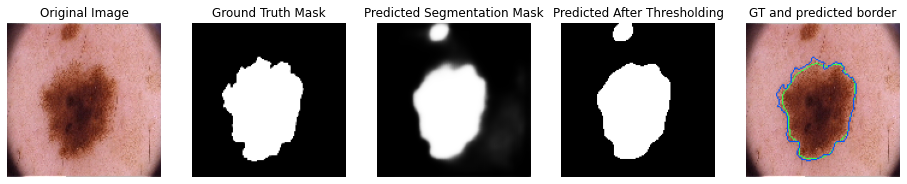

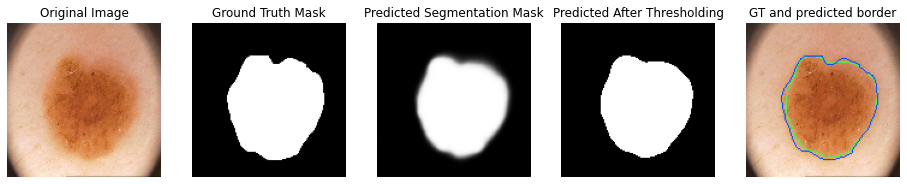

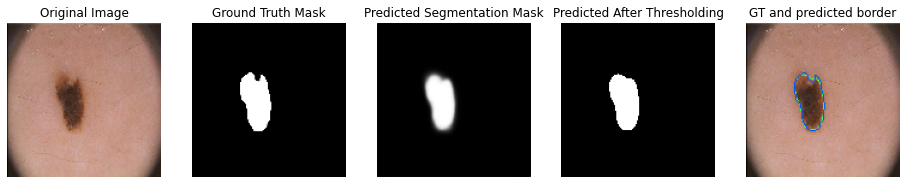

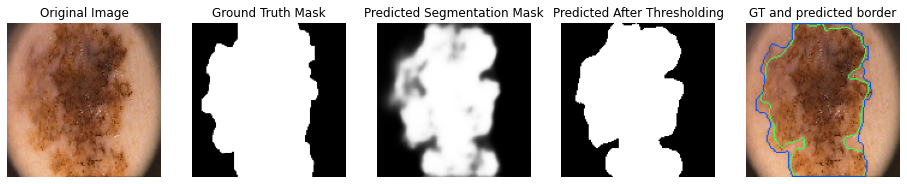

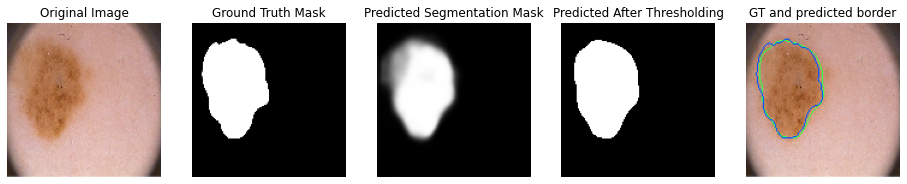

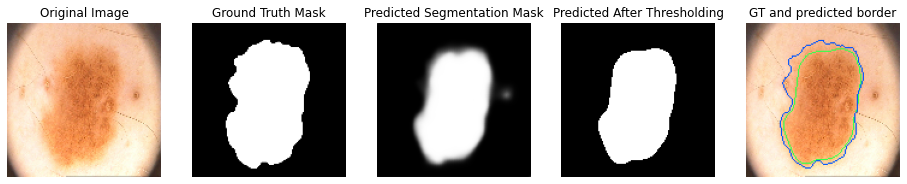

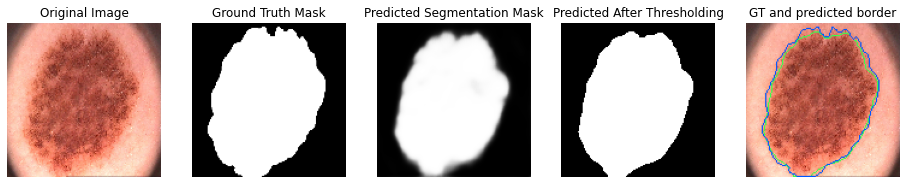

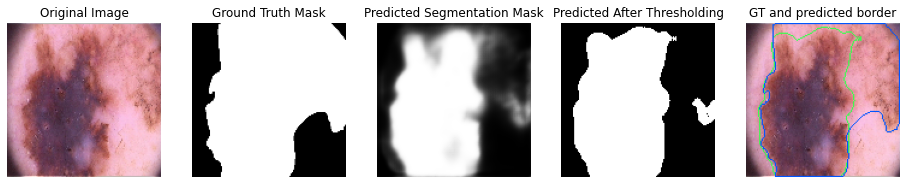

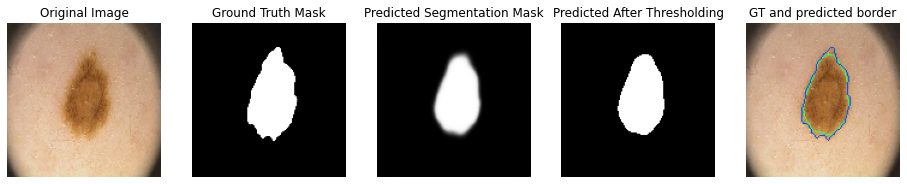

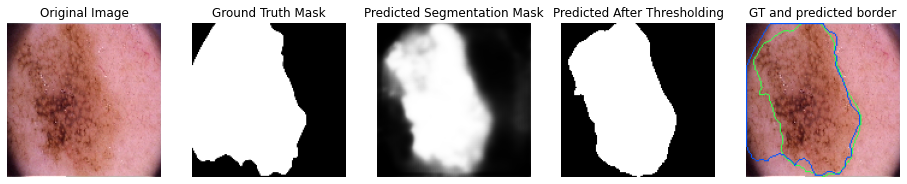

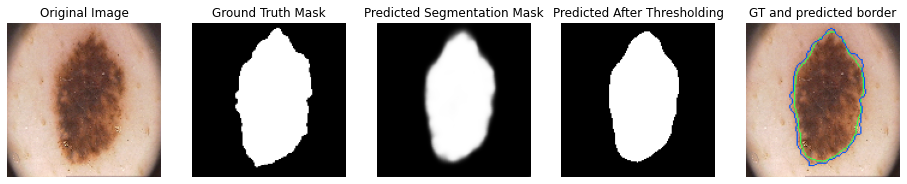

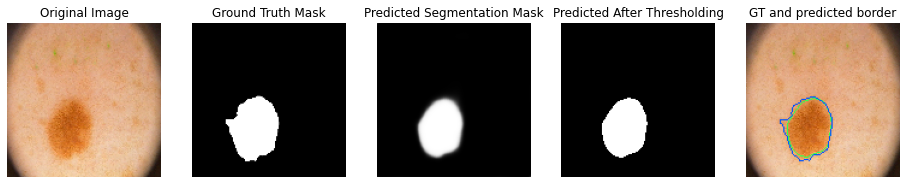

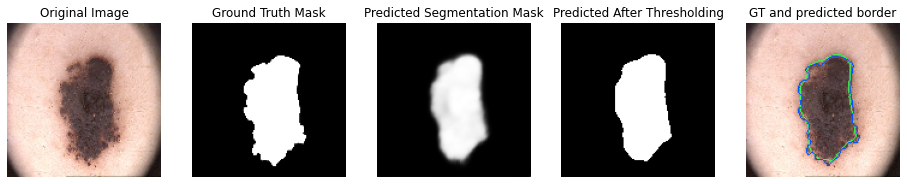

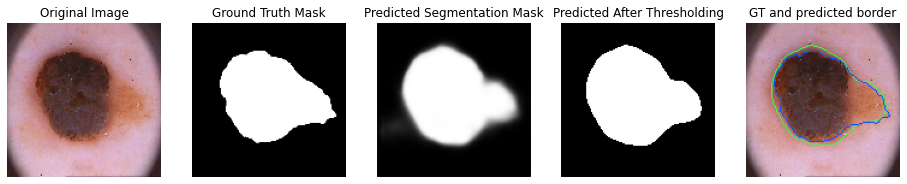

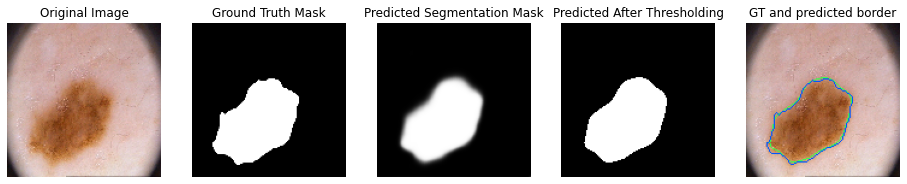

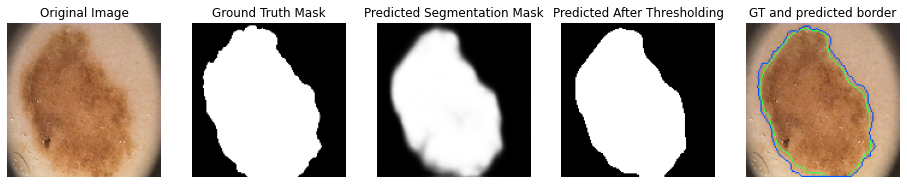

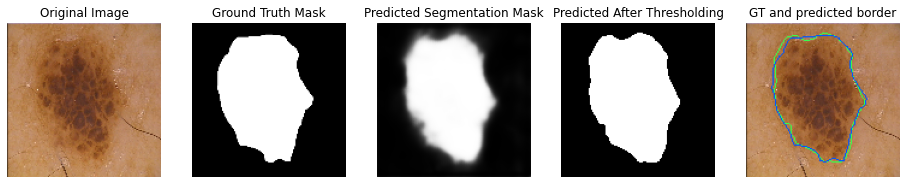

In [32]:
if os.path.exists(ph2_numpy_directory):
  display_image_results(ph2_test_data, ph2_test_mask, ph2_predictions, ph2_predictions_thresh)

###Evaluate PH2 trained model on ISIC data
The PH2 trained model is tested on the ISIC dataset and performance metrics are calculated

In [33]:
if os.path.exists(ph2_numpy_directory):
  isic_predictions_ph2_model = ph2_trained_model.predict(isic_test_data, batch_size=8, verbose=1)

  # Threshold
  isic_predictions_ph2_models_thresh   = np.where(isic_predictions_ph2_model>0.4, 1, 0)
  
  # Calculate metrics
  calc_metrics(isic_test_mask, isic_predictions_ph2_models_thresh)
  calculate_modified_hausdorff_distance(isic_test_mask, isic_predictions_ph2_models_thresh)

65/65 [==============================] - 4s 47ms/step
Border Error Metric mean: 43.532656628341435
TPR: 72.0247697546009
FPR: 4.3883074560804385
Modified Hausdorff Distance: 14.61272626457254


Example of predicted results

Ground truth border is represented by blue, and computer detected border is represented by green.

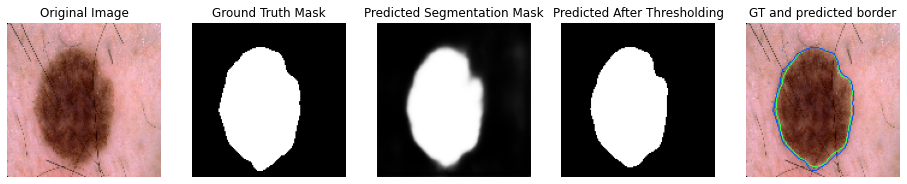

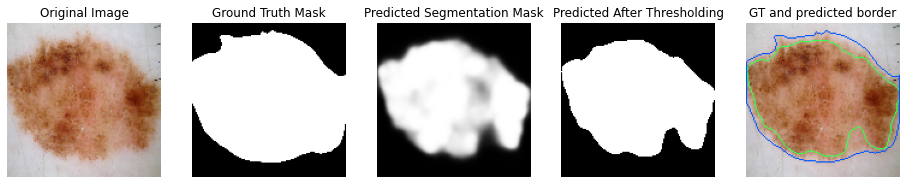

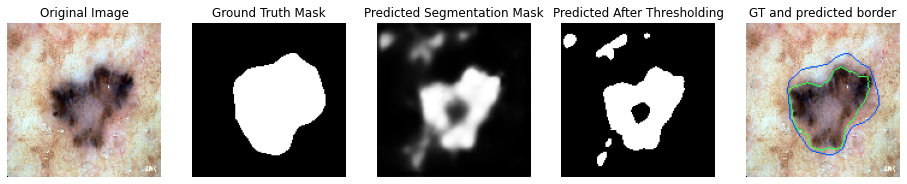

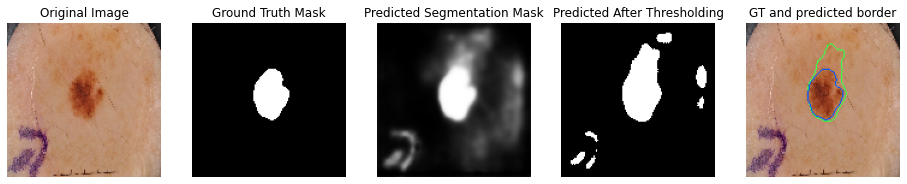

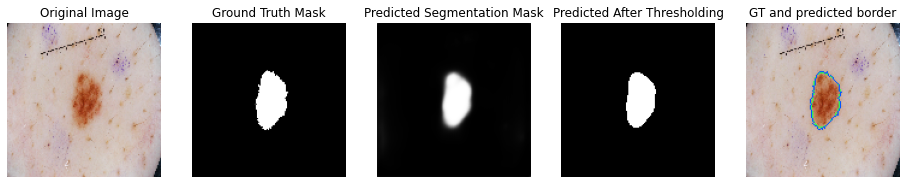

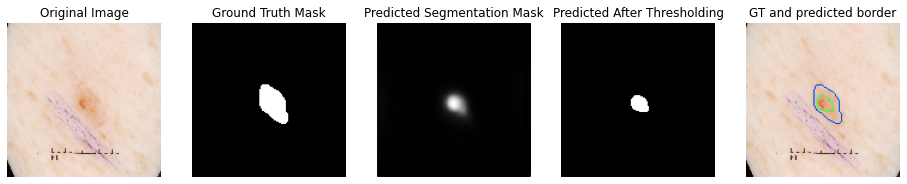

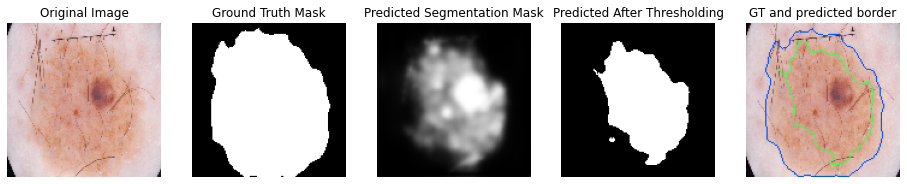

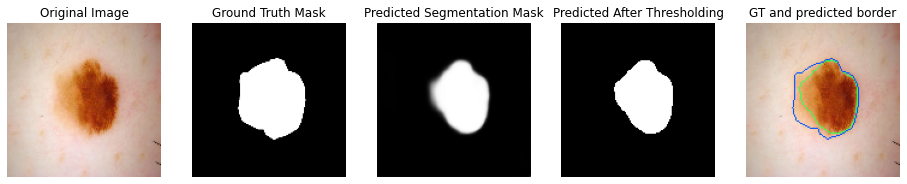

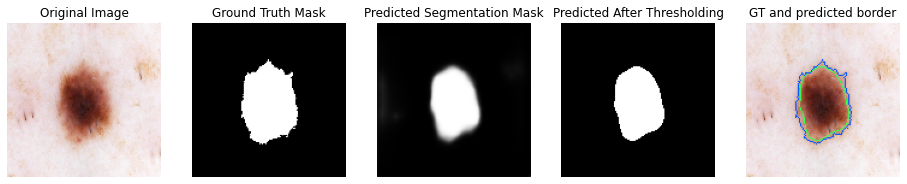

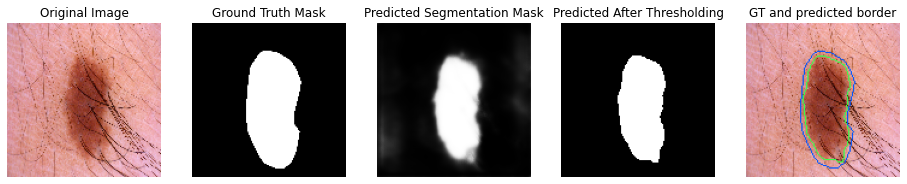

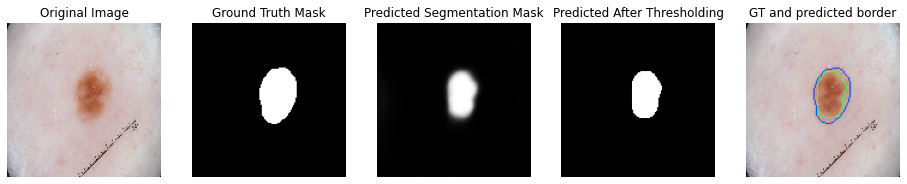

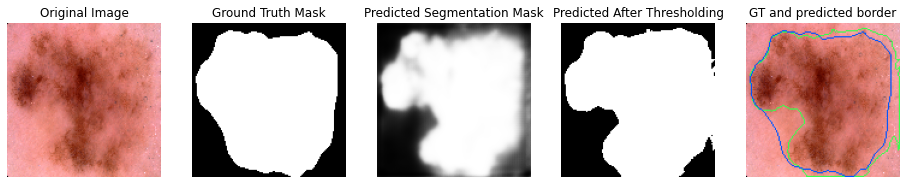

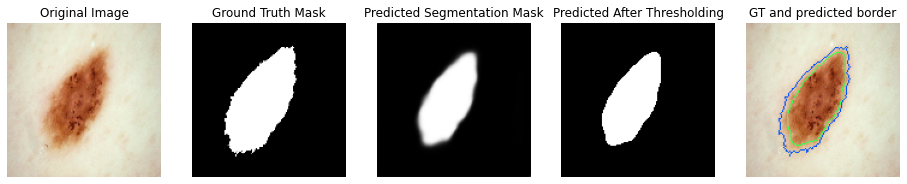

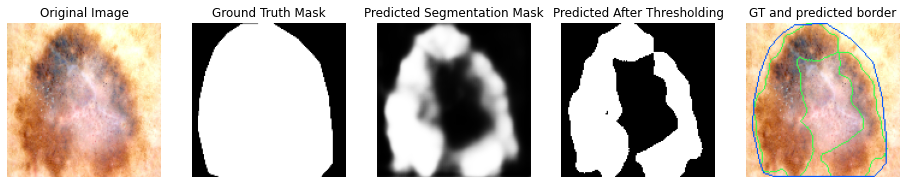

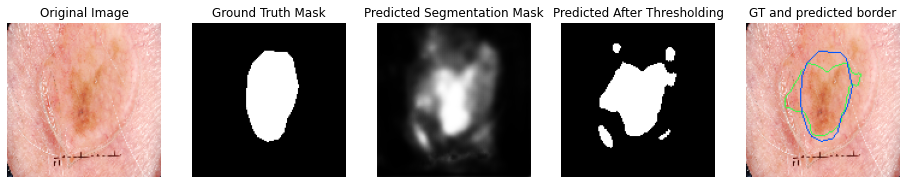

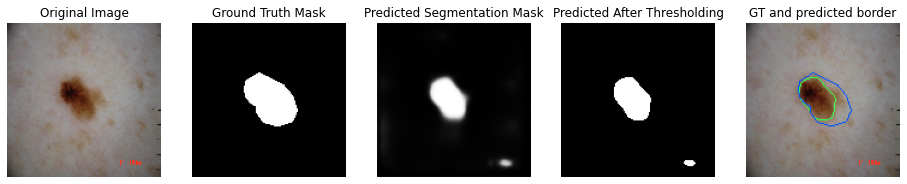

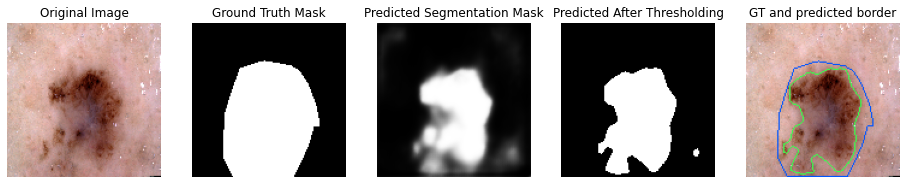

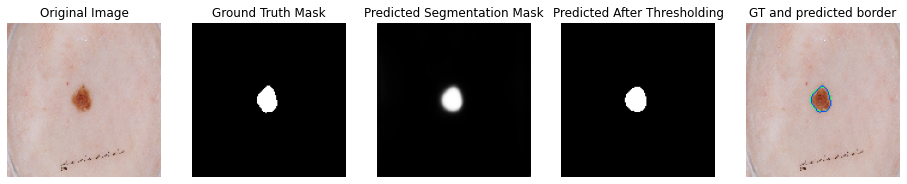

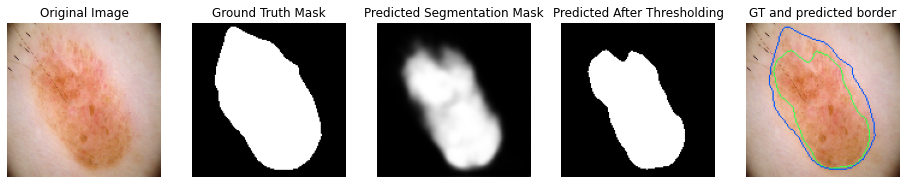

In [34]:
if os.path.exists(ph2_numpy_directory):
  display_image_results(isic_test_data, isic_test_mask, isic_predictions_ph2_model, isic_predictions_ph2_models_thresh)